## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalMaxPooling2D,
    Input,
    InputLayer,
    MaxPooling2D,
    Reshape,
)
from tensorflow.keras.models import Model, Sequential

In [33]:
# Check if gpu is detected
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
DATA_PATH = "data/"
OUTPUT_PATH = "output/"

# Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Eurybia :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


<span style="color:green">Answer:</span>
- Le modèle de classification permet de détecter les changements dans la distribution des données en comparant les données de production avec les données d'entraînement.
- Non, les labels ne sont pas nécessaire, puisque pour ce modèle, le label est l'origine des données (train ou prod).
- Le critère est la performance du modèle de classification, on l'évalue avec l'AUC (Area Under the Curve) et si elle est supérieure à un certain seuil (ici 0.5), on considère qu'il y a un data drift.

Installer eurybia

<span style="color:green">
    Done
</span>

Utiliser eurybia pour monitorer la distribution des données. Dans un premier temps faire en sorte que les données de prod (df_current) soient de la même distribution que vos données d’entraînement. Pour cela vous pouvez split le dataset en deux et décider que l'un est X_train et l'autre est X_prod. Vérifier que Eurybia pense que le modèle ne drift pas. Attention à ne pas inclure le label (qui serait ici price)



In [35]:
df_current = pd.read_csv(f"{DATA_PATH}/houses_2024.csv")
df_copy = df_current.copy()

df_current.head()

,size,nb_rooms,garden,orientation,price
0,215.775096,1,0,Ouest,243048.717637
1,247.064976,2,0,Nord,248116.081979
2,134.107329,2,1,Ouest,291773.127311
3,196.242198,3,1,Ouest,328799.458161
4,154.396906,1,1,Est,274069.213761


In [36]:
lb = LabelEncoder()
df_current["orientation"] = lb.fit_transform(df_current["orientation"])

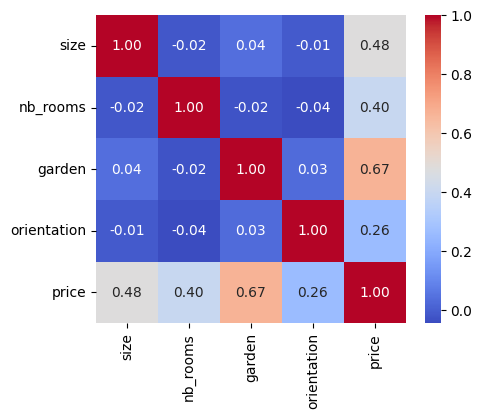

In [37]:
cor_table = df_current.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(cor_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### Without drift

In [38]:
# Cut in half the current data to simulate production data
X_train, X_prod = train_test_split(df_copy, test_size=0.5, random_state=42)

X_train.shape, X_prod.shape

((400, 5), (400, 5))

#### Eurybia

In [39]:
sd  = SmartDrift(
    df_current=X_prod,
    df_baseline=X_train,
    encoding=lb,
    dataset_names={"df_current": "Production data", "df_baseline": "Training data"},
)

In [40]:
sd.compile(
    ignore_cols=["price"]
)

The following variables are manually set to be ignored in the analysis: 
 ['price']


INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7b3973066400>


In [41]:
sd.generate_report(
    output_file=f"{OUTPUT_PATH}/drift_report_no_drift.html",
    title_story="Data Drift Report - No Drift",
    
)

App saved to ./output//drift_report_no_drift.html

Faire en sorte d'introduire un drift dans vos données. Par exemple (méthode assez bourine) ajouter +1 à la colonne nb_rooms. Relancer eurybia et vérifier que la performance du modèle est bonne et qu'il y a donc un datadrift

<span style="color:green">
    0.7 of AUC
</span>

In [42]:
# We change the prod data
X_prod[["nb_rooms"]] += 1

In [43]:
sd = SmartDrift(
    df_current=X_prod,
    df_baseline=X_train,
    encoding=lb,
    dataset_names={"df_current": "Production data", "df_baseline": "Training data"},
)

sd.compile(ignore_cols=["price"])

The following variables are manually set to be ignored in the analysis: 
 ['price']
INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7b3973697c70>


In [44]:
sd.generate_report(
    output_file=f"{OUTPUT_PATH}/drift_report_drift.html",
    title_story="Data Drift Report - With Drift",
)

App saved to ./output//drift_report_drift.html

Faire en sorte de faire un drift plus subtile mais remarquable. Eurybia est-il détectable avec Eurybia ?

<span style="color:green">
    0.48 or 0.52 of AUC
</span>

In [45]:
# Introduce a subtle drift by slightly increasing the 'size' column in X_train
X_train, X_prod = train_test_split(df_copy, test_size=0.5, random_state=42)
# Increase size by 7%
X_train["size"] = X_train["size"] * 1.07

In [46]:
sd = SmartDrift(
    df_current=X_prod,
    df_baseline=X_train,
    encoding=lb,
    dataset_names={"df_current": "Production data", "df_baseline": "Training data"},
)

sd.compile(ignore_cols=["price"])

The following variables are manually set to be ignored in the analysis: 
 ['price']
INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7b39b3cca5e0>


In [47]:
sd.generate_report(
    output_file=f"{OUTPUT_PATH}/drift_report_subtle_drift.html",
    title_story="Data Drift Report - With subtle Drift",
)

App saved to ./output//drift_report_subtle_drift.html

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

<span style="color:green">
    Done
</span>

Source: [CIFAR-10 Image Classification in TensorFlow](https://www.geeksforgeeks.org/deep-learning/cifar-10-image-classification-in-tensorflow/)

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [48]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [49]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

Dans le sous package alibi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [50]:
from alibi_detect.datasets import corruption_types_cifar10c, fetch_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [51]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez 1 ou 2 corruptions parmis les suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True
attention le dataset peut être lourd si vous utilisez bcp de corruptions

In [52]:
# Fetch corrupted CIFAR-10 data with 'gaussian_noise' and 'brightness' corruptions
X_corrupted, y_corrupted = fetch_cifar10c(
    corruption=['gaussian_noise', 'brightness'],
    severity=5,
    return_X_y=True
)

Normaliser les images corrompues

In [53]:
# Normaliser les images corrompues entre 0 et 1
X_corrupted = X_corrupted / 255.0

Afficher plusieurs des images corrompues.

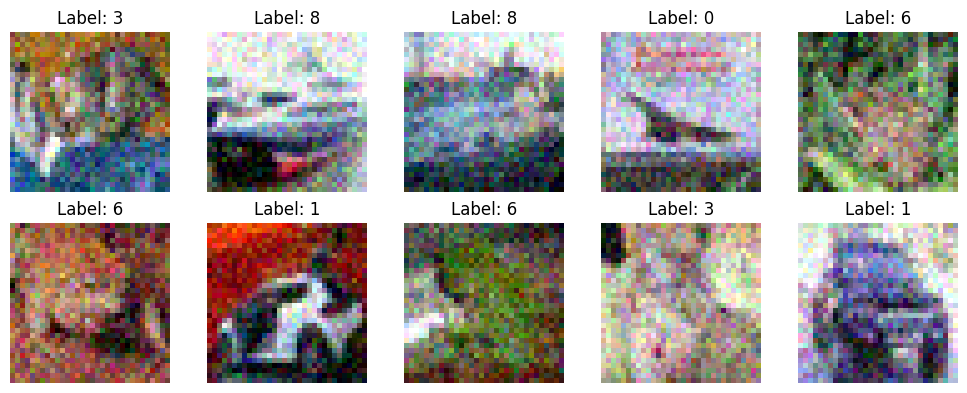

In [54]:
# Afficher plusieurs images corrompues
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_corrupted[i])
    plt.axis('off')
    plt.title(f"Label: {y_corrupted[i]}")
plt.tight_layout()
plt.show()

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [55]:
from alibi_detect.utils.fetching import fetch_detector, fetch_tf_model

dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

Calculer la performance du model sur le jeu de train et de test

In [56]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

2025-09-25 11:28:00.947743: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Train accuracy: 0.6163
Test accuracy: 0.6043


Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [57]:
corrupted_loss, corrupted_acc = model.evaluate(X_corrupted, y_corrupted, verbose=0)
print(f"Corrupted data accuracy: {corrupted_acc:.4f}")
print(f"Corrupted data loss: {corrupted_loss:.4f}")

Corrupted data accuracy: 0.3684
Corrupted data loss: 4.5535


On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [58]:
from functools import partial

from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [59]:
# 1000 random samples from the test set as reference data
X_ref = x_test[np.random.choice(x_test.shape[0], 1000, replace=False)]

A quoi sert le test statistique kolmogorov smirnoff ?

<span style="color:green">
    Answer:
</span>

Le test statistique de Kolmogorov-Smirnov (KS) permet de comparer la distribution d'un échantillon à une distribution de référence (test univarié), ou de comparer deux échantillons entre eux.

Il mesure la distance maximale entre les fonctions de répartition cumulée des deux distributions. Il sert à détecter si les deux distributions sont significativement différentes, ce qui est utile pour identifier un changement de distribution (data drift) dans les données.

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [60]:
from alibi_detect.cd import KSDrift
from alibi_detect.cd.tensorflow import preprocess_drift

preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

detector = KSDrift(X_ref, p_val=0.05, preprocess_fn=preprocess_function)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution

In [61]:
# Use the drift detector to predict on test and corrupted data
result_test = detector.predict(x_test)
result_corrupted = detector.predict(X_corrupted)

print("Test set drift detected:", result_test['data']['is_drift']) # type: ignore
print("Corrupted set drift detected:", result_corrupted['data']['is_drift']) # type: ignore
print("Test set p-value:", result_test['data']['p_val'])
print("Corrupted set p-value:", result_corrupted['data']['p_val'])

Test set drift detected: 0
Corrupted set drift detected: 1
Test set p-value: [0.81401676 0.91225654 0.67775637 0.61678153 0.905648   0.8317434
 0.98138875 0.9489451  0.7429408  0.3284949  0.9465199  0.41686502
 0.22703719 0.49373934 0.6828284  0.8651292  0.80492824 0.82295835
 0.10772128 0.94402766 0.34740046 0.98138875 0.31749153 0.8488057
 0.63708544 0.9773985  0.9787876  0.70808095 0.25996068 0.47968906
 0.98138875 0.6016118 ]
Corrupted set p-value: [3.2789069e-29 3.0417378e-23 8.7357420e-16 1.9992679e-06 5.1170452e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.4994523e-39 2.9162696e-01
 2.5185581e-14 0.0000000e+00 2.6466954e-14 4.8506255e-03 1.3406048e-08
 0.0000000e+00 0.0000000e+00 4.4702720e-02 9.2513584e-02 2.2037193e-06
 0.0000000e+00 6.3815632e-16 1.8445717e-01 1.2198057e-01 2.6219611e-03
 2.4770192e-40 6.4347625e-42 8.6600245e-43 7.8455424e-01 1.3304797e-01
 3.4480549e-02 1.1137468e-24]
